In [1]:
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 5000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE"},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1},
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },        
}

pipe = RubixPipeline(config)

data= pipe.run()

2024-05-20 16:07:10,827 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <  
/_/|_|\____/____/___/_/|_|  
                            

2024-05-20 16:07:10,828 - rubix - INFO - Rubix version: 0.0.1.post55+g93a544d
/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:21: UserWarning: No telescope config provided, using default stored in /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2024-05-20 16:07:11,231 - rubix - INFO - Getting rubix data...
2024-05-20 16:07:11,232 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2024-05-20 16:07:13,233 - rubix - WARNING - The Subset value is set in config. Using only subset of size 5000
2024-05-20 16:07:13,235 - rubix - INFO - Data loaded with 5000 particles.
2024-05-20 16:07:13,235 - rubix - DEBUG - Data Shape: {'coords': (5000, 3), 'velocities': (5000, 3), 'metallicity': (5000,), 'mass': (5000,), 'age'

rotating galaxy:  face-on


2024-05-20 16:07:13,817 - rubix - DEBUG - Calculation Finished! Spectra shape: (1, 5000, 842)


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function expr at /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/pipeline/linear_pipeline.py:150 for jit. This concrete value was not available in Python because it depends on the values of the arguments input['age'] and input['metallicity'].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [9]:
from rubix.core.ssp import get_lookup
import jax.numpy as jnp

lookup = get_lookup(config)
print(lookup)

metallicity = pipe.data["metallicity"]
print(metallicity)
age = pipe.data["age"]
print(age)

spec = lookup(metallicity,age)

jnp.isnan(spec).any()

2024-05-20 16:11:54,868 - rubix - DEBUG - Method not defined, using default method: cubic


Partial(<PjitFunction of <function interp2d at 0x74b3cc95f240>>, method='cubic', x=Array([1.e-04, 4.e-04, 4.e-03, 8.e-03, 2.e-02, 5.e-02], dtype=float32), y=Array([ 0.       ,  5.100002 ,  5.1500006,  5.1999993,  5.25     ,
        5.3000016,  5.350002 ,  5.4000006,  5.4500012,  5.500002 ,
        5.550002 ,  5.600002 ,  5.6500025,  5.700002 ,  5.750002 ,
        5.8000026,  5.850003 ,  5.900003 ,  5.950003 ,  6.       ,
        6.0200005,  6.040001 ,  6.0599985,  6.0799985,  6.100002 ,
        6.120001 ,  6.1399984,  6.16     ,  6.18     ,  6.1999993,
        6.2200007,  6.24     ,  6.2599998,  6.2799997,  6.2999997,
        6.3199987,  6.3399997,  6.3600006,  6.3799996,  6.3999987,
        6.4200006,  6.44     ,  6.4599996,  6.4799995,  6.499999 ,
        6.52     ,  6.539999 ,  6.56     ,  6.5799994,  6.6      ,
        6.6199994,  6.6399994,  6.66     ,  6.679999 ,  6.699999 ,
        6.72     ,  6.7399993,  6.7599993,  6.7799997,  6.799999 ,
        6.819999 ,  6.839999 ,  6.85999

Array(False, dtype=bool)

[0.04939644 0.00570401 0.02391632 ... 0.00249604 0.03057872 0.02657328]
[10.15793272  9.98624174  9.44847396 ... 12.01613657  6.95980435
  9.94907104]


AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'is_nan'

(1, 5000, 3721)


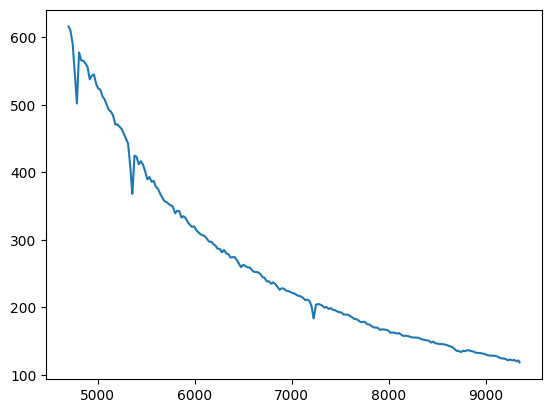

In [2]:
import matplotlib.pyplot as plt
wave = pipe.telescope.wave_seq
spectra = data["spectra"] # Spectra of all stars
print(spectra.shape)

plt.plot(wave, spectra[0,3]) 


Some of the spectra may be zero, this happens if the metallicity or age values are outside the range of the SSP model. This is currently the expected behavior

In [5]:
import jax 
import jax.numpy as jnp
# Create a function to calculate a single IFU cube
def calculate_ifu_cube(stars_spectra, pixel_indices):
    # Create an IFU cube of shape (25*25, 842)
    #ifu_cube = jnp.zeros((25 * 25, 842))
    
    # Use jax.ops.segment_sum to sum the spectra into the IFU cube based on pixel indices
    ifu_cube = jax.ops.segment_sum(stars_spectra, pixel_indices, num_segments=25*25)
    
    # Reshape the IFU cube to the desired shape (25, 25, 842)
    ifu_cube = ifu_cube.reshape((25, 25, 3721))
    
    return ifu_cube

spectra = data["spectra"]
assignments = data["pixel_assignment"]

# Calculate 4 individual IFU cubes
ifu_cubes = jax.vmap(calculate_ifu_cube)(spectra, assignments)

# Sum the 4 IFU cubes
final_ifu_cube = jnp.sum(ifu_cubes, axis=0)
final_ifu_cube.shape

(25, 25, 3721)

In [6]:

wavelengths = pipe.telescope.wave_seq

# get the indices of the visible wavelengths of 4000-8000 Angstroms

visible_indices = jnp.where((wavelengths >= 4000) & (wavelengths <= 8000))



In [9]:
wavelengths

Array([4700.15, 4701.4 , 4702.65, ..., 9347.65, 9348.9 , 9350.15],      dtype=float32)

In [21]:
spectra[0,7]

Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

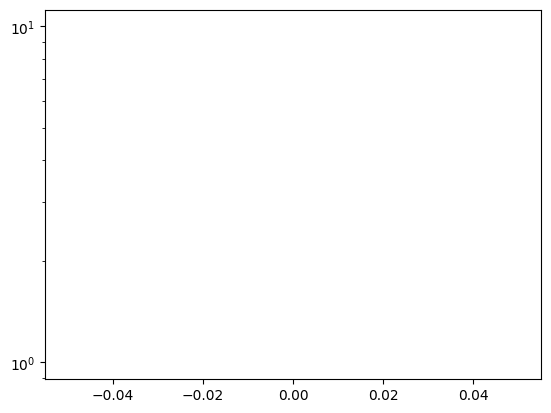

In [7]:
# plot example spectrum
import matplotlib.pyplot as plt

spec = final_ifu_cube[12, 12]

plt.plot(wavelengths[visible_indices], spec[visible_indices])
plt.yscale("log")

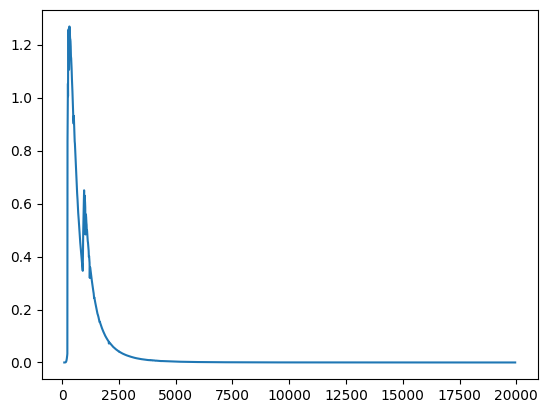

In [ ]:
plt.plot(wavelengths,ssp.flux[0,0])

In [ ]:
visible_indices[0].shape

(200,)

In [ ]:
# get the spectra of the visible wavelengths from the ifu cube
visible_spectra = final_ifu_cube[:, :, visible_indices[0]]
visible_spectra.shape

(25, 25, 200)

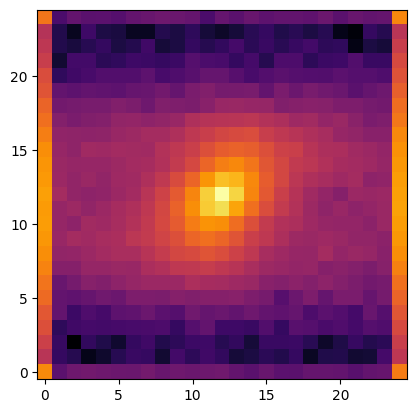

In [ ]:
# Sum up all spectra to create an image
image = jnp.sum(visible_spectra, axis = 2)
image = jnp.log10(image + 1)
plt.imshow(image, origin="lower", cmap="inferno")